# CHALLENGE: Time Series Analysis: Criptomonedas

### Este ejercicio ha sido propuesto y creado íntegramente por el equipo de AI Saturdays Euskadi, tomando adaptaciones de otras fuentes (thanks [@MaialenBerrondo](https://www.linkedin.com/in/maialen-berrondo-43197b94/)!)

Un caso habitual de trabajo de análisis de Time Series es el referido a diferentes activos de Bolsa. En este ejercicio, vamos a trabajar con un dataset que contiene una serie de valores de una criptomoneda específica (<a href="https://en.wikipedia.org/wiki/Ripple_(payment_protocol)">XRP</a>). XRP es una de las criptomonedas más populares que recientemente obtuvo la segunda posición en términos de capitalización de mercado y que también tiene un gran potencial en el futuro, en términos de velocidad de pago y transacciones. De hecho, a menudo se hace referencia a XRP como la "moneda de los banqueros", ya que las instituciones y los bancos se han asociado con Ripple para sus diferentes procedimientos de mejora de transacciones.

<p style="text-align: justify">Los datos históricos de la moneda han sido tomados de la web haciendo webscraping mediante la librería <a href="https://www.crummy.com/software/BeautifulSoup/">Beautiful Soup</a> y se han guardado en formato <em>CSV</em>.

<p style="text-align: justify">El dataset <b>"XRP_price"</b> es un conjunto de datos de series temporales multivariante que describe el precio histórico de la moneda desde casi su debut como moneda de cambio. Los datos van de agosto de 2013 a diciembre de 2018, con observaciones diarias de las diferentes cantidades. Es una serie multivariante compuesta por 3 variables (además de la fecha y la hora); son:</p>

<ul>
<li><strong>Close XRP</strong>: El precio de cierre diario de la criptomoneda (USD).</li>
<li><strong>Volume XRP</strong>: El volumen diario total de la moneda (USD).</li>
<li><strong>Market Cap</strong>: La capitalización de mercado diaria total de la moneda (USD).</li>
</ul>

In [34]:
# import regular libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from SciPy packages
from statsmodels.tsa.stattools import adfuller # adfuller test
from statsmodels.graphics.tsaplots import plot_acf # autocorellation plot
from statsmodels.graphics.tsaplots import plot_pacf # partial autocorellation plot

# math function
from math import sqrt

# evaluation metrics
from sklearn.metrics import mean_squared_error

# statistics models
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# libraries to filter warnings in some algorithms
import warnings
warnings.filterwarnings("ignore")

## 1. Load datatset

Tips: 
* Are there any NaN values?
* Are all values numeric?

In [35]:
df = pd.read_csv('XRP_price.csv', header=0, infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
df.head()

,Close XRP,Volume XRP,Market Cap XRP
Date,,,
2013-08-05,0.005613,NaN,43879157
2013-08-06,0.004680,NaN,36591008
2013-08-07,0.004417,NaN,34534121
2013-08-08,0.004254,NaN,33258632
2013-08-09,0.004291,NaN,33547503


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1960 entries, 2013-08-05 to 2018-12-16
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close XRP       1960 non-null   float64
 1   Volume XRP      1816 non-null   float64
 2   Market Cap XRP  1960 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 61.2 KB


In [37]:
df.describe()

,Close XRP,Volume XRP,Market Cap XRP
count,1960.000000,1.816000e+03,1.960000e+03
mean,0.164995,2.159157e+08,6.352882e+09
std,0.341782,7.088785e+08,1.334716e+10
min,0.002810,8.316000e+03,2.196991e+07
25%,0.006315,3.563672e+05,1.735673e+08
50%,0.008615,1.110490e+06,2.580457e+08
75%,0.211142,1.671492e+08,8.117047e+09
max,3.380000,9.110440e+09,1.308535e+11


In [38]:
df.isnull().sum()

Close XRP           0
Volume XRP        144
Market Cap XRP      0
dtype: int64

In [39]:
df.fillna(value=0, inplace=True)
df.isnull().sum()

Close XRP         0
Volume XRP        0
Market Cap XRP    0
dtype: int64

In [40]:
dataset = df.astype('float32')
df.head()

,Close XRP,Volume XRP,Market Cap XRP
Date,,,
2013-08-05,0.005613,0.0,43879157
2013-08-06,0.004680,0.0,36591008
2013-08-07,0.004417,0.0,34534121
2013-08-08,0.004254,0.0,33258632
2013-08-09,0.004291,0.0,33547503


## 2. Visualize the data

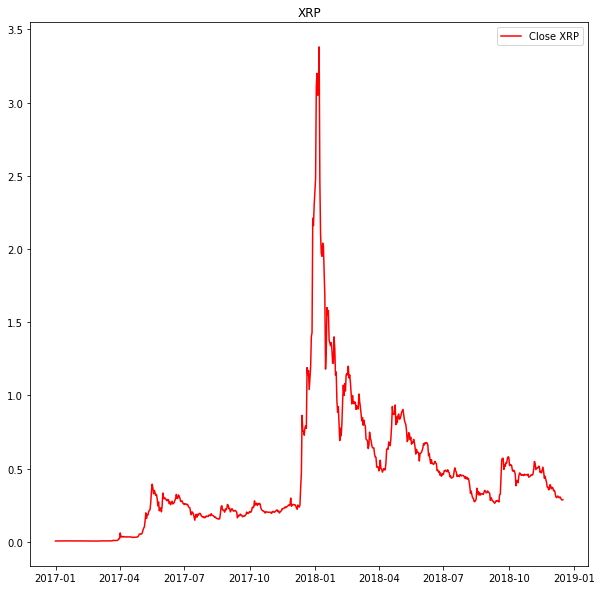

In [79]:
plt.figure(figsize = (10,10))
plt.plot(df.loc['2017-01-01':,'Close XRP'], color='red', label='Close XRP')
plt.legend(loc='best')
plt.title('XRP')
plt.show();

## 3. Autocorrelation Analysis

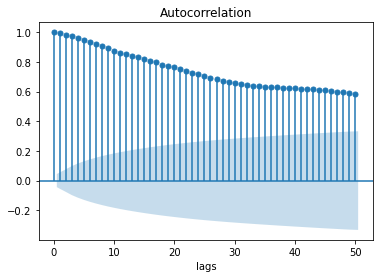

In [42]:
plot_acf(df.iloc[:,0], lags=50)
plt.xlabel('lags')
plt.show()

## 4. Augmented Dickey-Fuller test

In [43]:
print('Augmented Dickey-Fuller test:')
print('\n\t{0}:'.format(df.columns[0]))
df_test = adfuller(df.iloc[:,0])
df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print("df_output:\n{0}\n".format(df_output))
for key,value in df_test[4].items():
    df_output['Critical Value (%s)'%key] = value
print(df_output)

Augmented Dickey-Fuller test:

	Close XRP:
df_output:
Test Statistic                   -3.122826
p-value                           0.024909
#Lags Used                       26.000000
Number of Observations Used    1933.000000
dtype: float64

Test Statistic                   -3.122826
p-value                           0.024909
#Lags Used                       26.000000
Number of Observations Used    1933.000000
Critical Value (1%)              -3.433737
Critical Value (5%)              -2.863036
Critical Value (10%)             -2.567567
dtype: float64


## 5. Evaluation metric

In [44]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        rmse = sqrt(mse)
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

## 6. Split train and test

In [45]:
def split_dataset(data, n_test):
    train, test = data[0:-n_test], data[-n_test:]
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

def to_series(data):
    series = [week[:, 0] for week in data]
    series = np.array(series).flatten()
    return series

train, test = split_dataset(df.values,714)

## 7. Define a Validation stategy

Walk-forward validation. Models will be evaluated using a scheme called walk-forward validation.

This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week. This is both realistic for how the model may be used in practice and beneficial to the models allowing them to make use of the best available data.

We can demonstrate this below with separation of input data and output/predicted data.
Input,                         Predict
[Week1]                        Week2
[Week1 + Week2]                Week3
[Week1 + Week2 + Week3]        Week4

The walk-forward validation approach to evaluating predictive models on this dataset is implement below, named evaluate_model().

The name of a function is provided for the model as the argument "model_func";. This function is responsible for defining the model, fitting the model on the training data, and making a one-week forecast.

The forecasts made by the model are then evaluated against the test dataset using the previously defined evaluate_forecasts() function. 

**If you don't understand the explanation, feel free to ask or check the solution, feel free to define another valiation stategy if you prefer so!**

In [46]:
def evaluate_model(model_func, train, test, *args):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        y_hat_seq = model_func(history, *args)
        predictions.append(y_hat_seq)
        history.append(test[i,:])
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions

def evaluate_arima_family_scores(func, name, train, test, order, debug = False):
    score = None
    if debug:
        score, scores, predictions = evaluate_model(func, train, test, order)
    else:
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                score, scores, predictions = evaluate_model(func, train, test, order)
        except:
            score = None 
    if score is not None: 
        print(name + '%s RMSE=%.3f' % (order,score))
    return (order, score)

## 8. Choose and train a model

In the solution ARIMA and SARIMA models are used. SARIMA is a variation of ARIMA where seasonality is introduced. You can check it in here (https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/).

In [47]:
def arima_forecast(history, arima_order):
    series = to_series(history)
    model = ARIMA(series, order=arima_order)
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

def Sarima_forecast(history, config):
    order, sorder, trend = config
    series = to_series(history)
    model = SARIMAX(series, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

In [48]:
import itertools

p = q = range(0, 4)
r = range(0,2)

orders = itertools.product(p, r, q)
for param in orders:
    try:
        mod = ARIMA(df.iloc[:,0],order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{} - MSE:{}'.format(param, results.aic, np.sum(np.square(results.resid))))
    except:
        continue

ARIMA(0, 0, 0) - AIC:1356.7959880328308 - MSE:228.84037784387533
ARIMA(0, 0, 1) - AIC:-1121.6595898573278 - MSE:64.49230547764846
ARIMA(0, 1, 0) - AIC:-6733.752763180035 - MSE:3.6800583318532936
ARIMA(0, 1, 1) - AIC:-6742.163762042722 - MSE:3.660543603489783
ARIMA(0, 1, 2) - AIC:-6744.020526081044 - MSE:3.653338098343087
ARIMA(0, 1, 3) - AIC:-6746.699874004497 - MSE:3.6446102538186143
ARIMA(1, 0, 0) - AIC:-6739.780214055839 - MSE:3.690045613191311
ARIMA(1, 0, 1) - AIC:-6749.3101786943835 - MSE:3.6685887691308445
ARIMA(1, 0, 2) - AIC:-6751.894520142486 - MSE:3.660099448762765
ARIMA(1, 0, 3) - AIC:-6755.477674149756 - MSE:3.6497699468498626
ARIMA(1, 1, 0) - AIC:-6743.132601265584 - MSE:3.6587319936214584
ARIMA(1, 1, 1) - AIC:-6755.8885277118325 - MSE:3.631236742314738
ARIMA(1, 1, 2) - AIC:-6754.00406036054 - MSE:3.6310203592056265
ARIMA(1, 1, 3) - AIC:-6753.332745150255 - MSE:3.6285477472773238
ARIMA(2, 0, 0) - AIC:-6750.500689405021 - MSE:3.666384625534071
ARIMA(2, 0, 1) - AIC:-6768.808

### 8.1 Grid search for time series models

You can try to search the best parameters for the model with ML parameters searching tecniques. In the following notebook you can have an explained procedure (Grid_search_models_hyperparameters.ipynb)

In [49]:
def grid_search_arima_family(func, name, train, test, orders_list, parallel=True):
    scores = None
    if parallel:
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(evaluate_arima_family_scores)(func, name, train, test, order) for order in orders_list)
        scores = executor(tasks)
    else:
        scores = [evaluate_arima_family_scores(func, name, train, test, order) for order in orders_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    return scores, name

def arima_orders(p_values, d_values, q_values):
    orders = list()
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                orders.append(order)
    return orders

def Sarima_configs(seasonal=[0]):
    configs = list()
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    configs.append(cfg)
    return configs

## 9. Make some predictions!

In [50]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

models = dict()
models['Arima'] = arima_forecast
models['Sarima'] = Sarima_forecast

p_values = range(0, 8)
d_values = range(0, 3)
q_values = range(0, 2)

orders_arima_list = arima_orders(p_values,d_values,q_values)
configs_sarima_list = Sarima_configs(seasonal=[0])

args = list() 
args.extend([orders_arima_list, configs_sarima_list])

for (name, func), arg in zip(models.items(), args): 
    scores, name = grid_search_arima_family(func, name, train, test, arg, parallel=False)
    print('\n')
    print('Top 3 best performing {0} models:'.format(name))
    for order, error in scores[:3]: 
        print(name + str(order), 'RMSE = ' + str(error)) 
    print('\n')

Arima(0, 0, 0) RMSE=0.567
Arima(0, 0, 1) RMSE=0.537
Arima(0, 1, 0) RMSE=0.628
Arima(0, 1, 1) RMSE=0.628
Arima(0, 2, 0) RMSE=0.629
Arima(0, 2, 1) RMSE=0.628
Arima(1, 0, 0) RMSE=0.195
Arima(1, 1, 0) RMSE=0.628
Arima(1, 1, 1) RMSE=0.620
Arima(1, 2, 0) RMSE=0.629
Arima(1, 2, 1) RMSE=0.628
Arima(2, 0, 0) RMSE=0.196
Arima(2, 1, 0) RMSE=0.628
Arima(2, 1, 1) RMSE=0.626
Arima(2, 2, 0) RMSE=0.629
Arima(2, 2, 1) RMSE=0.628
Arima(3, 0, 0) RMSE=0.199
Arima(3, 1, 0) RMSE=0.628
Arima(3, 1, 1) RMSE=0.625
Arima(3, 2, 0) RMSE=0.629
Arima(4, 0, 0) RMSE=0.201
Arima(4, 1, 0) RMSE=0.627
Arima(4, 1, 1) RMSE=0.624
Arima(4, 2, 0) RMSE=0.628
Arima(5, 0, 0) RMSE=0.199
Arima(5, 1, 0) RMSE=0.626
Arima(5, 1, 1) RMSE=0.624
Arima(5, 2, 0) RMSE=0.629
Arima(6, 0, 0) RMSE=0.226
Arima(6, 1, 0) RMSE=0.624
Arima(6, 1, 1) RMSE=0.620
Arima(6, 2, 0) RMSE=0.630
Arima(6, 2, 1) RMSE=0.630
Arima(7, 0, 0) RMSE=0.231
Arima(7, 1, 0) RMSE=0.621
Arima(7, 1, 1) RMSE=0.617
Arima(7, 2, 0) RMSE=0.633
Arima(7, 2, 1) RMSE=0.633


Top 3 best

### 9.1 Don't forget to plot your predictions 

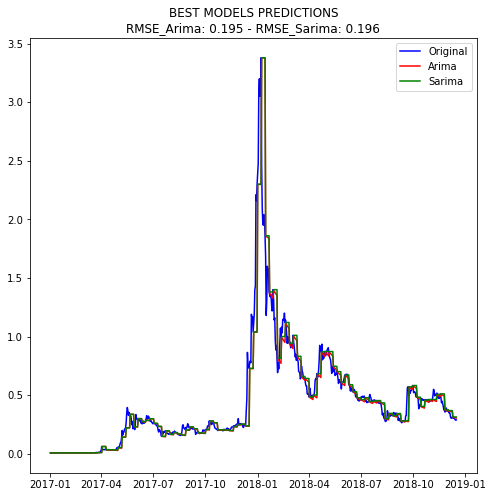

In [77]:
score_arima, scores_arima, predictions_arima = evaluate_model(arima_forecast, train, test, (1,0,0))
score_sarima, scores_sarima, predictions_sarima = evaluate_model(Sarima_forecast, train, test, [(0, 1, 0), (0, 0, 0, 0), 'n'])

predictions = pd.DataFrame()
predictions['Original'] = to_series(test)
predictions['Arima'] = to_series(predictions_arima[:,:,np.newaxis])
predictions['Sarima'] = to_series(predictions_sarima[:,:,np.newaxis])
predictions.set_index([df.index[1246:]], inplace=True)

plt.figure(figsize = (8,8))
plt.plot(predictions.Original, color='blue', label='Original')
plt.plot(predictions.Arima, color='red', label='Arima')
plt.plot(predictions.Sarima, color='green', label='Sarima')

plt.legend(loc='best')

plt.title('BEST MODELS PREDICTIONS\nRMSE_Arima: %.3f - RMSE_Sarima: %.3f'% (score_arima, score_sarima))
plt.show()